In [41]:
# Import required libraries
import fastf1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap, Normalize
import warnings
warnings.filterwarnings('ignore')
import os

# Setup cache
cache_dir = '/tmp/fastf1_cache'
os.makedirs(cache_dir, exist_ok=True)
fastf1.Cache.enable_cache(cache_dir)

# Create output directory
os.makedirs('../f1_visualizations', exist_ok=True)

print("✓ Libraries imported and cache configured")

✓ Libraries imported and cache configured


## 1. Load Sessions

Load qualifying and race sessions for comparison.

In [42]:
# Configuration
YEAR = 2025
RACE = 'Qatar'
DRIVER = 'VER'

print(f"Loading {YEAR} {RACE} sessions...")
print("="*80)

# Load qualifying
quali = fastf1.get_session(YEAR, RACE, 'Q')
quali.load()
print(f"✓ Qualifying loaded: {len(quali.laps)} total laps")

# Load race
race = fastf1.get_session(YEAR, RACE, 'R')
race.load()
print(f"✓ Race loaded: {len(race.laps)} total laps")

print("\n" + "="*80)

events      WARNING 	Correcting user input 'Qatar' to 'Qatar Grand Prix'
core           INFO 	Loading data for Qatar Grand Prix - Qualifying [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


Loading 2025 Qatar sessions...


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['81', '4', '1', '63', '12', '6', '55', '14', '10', '16', '27', '30', '87', '5', '23', '22', '31', '44', '18', '43']
events      WARNING 	Correcting user input 'Qatar' to 'Qatar Grand Prix'
core           INFO 	Loading data for Qatar Grand Prix - Race [v3.7.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing

✓ Qualifying loaded: 358 total laps


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '81', '55', '4', '12', '63', '14', '16', '30', '22', '23', '44', '5', '43', '31', '10', '18', '6', '87', '27']


✓ Race loaded: 1067 total laps



## 2. Select Laps to Compare

In [43]:
# Get driver's laps
driver_quali_laps = quali.laps.pick_drivers(DRIVER)
driver_race_laps = race.laps.pick_drivers(DRIVER)

print(f"{DRIVER}'s laps:")
print(f"  Qualifying: {len(driver_quali_laps)}")
print(f"  Race: {len(driver_race_laps)}")

# Select specific laps
quali_fastest = driver_quali_laps.pick_fastest()
race_lap_5 = driver_race_laps[driver_race_laps['LapNumber'] == 5].iloc[0]
third_last_lap_num = driver_race_laps['LapNumber'].max() - 2
race_lap_late = driver_race_laps[driver_race_laps['LapNumber'] == third_last_lap_num].iloc[0]

print(f"\n✓ Selected laps:")
print(f"  Quali fastest: Lap {quali_fastest['LapNumber']} - {format_laptime(quali_fastest['LapTime'])}")
print(f"  Race lap 5: {format_laptime(race_lap_5['LapTime'])}")
print(f"  Race lap {third_last_lap_num}: {format_laptime(race_lap_late['LapTime'])}")

VER's laps:
  Qualifying: 23
  Race: 57

✓ Selected laps:
  Quali fastest: Lap 22.0 - 1:19.651
  Race lap 5: 1:26.843
  Race lap 55.0: 1:24.405


## 3. Analysis Functions

In [44]:
def format_laptime(laptime):
    """
    Format lap time as M:SS.mmm
    """
    total_seconds = laptime.total_seconds()
    minutes = int(total_seconds // 60)
    seconds = total_seconds % 60
    return f"{minutes}:{seconds:06.3f}"

def compare_mini_sectors_with_telemetry(lap1, lap2, num_mini_sectors=20):
    """
    Compare two laps by creating segments and calculating time deltas.
    
    Parameters:
    lap1: Reference lap (baseline)
    lap2: Comparison lap
    num_mini_sectors: Number of segments to divide the lap into
    
    Returns:
    DataFrame with segment comparison data including X, Y positions
    """
    # Get telemetry for both laps
    tel1 = lap1.get_telemetry().add_distance()
    tel2 = lap2.get_telemetry().add_distance()
    
    track_length = tel1['Distance'].max()
    segment_length = track_length / num_mini_sectors
    
    comparison_data = []
    
    for i in range(num_mini_sectors):
        start_dist = i * segment_length
        end_dist = (i + 1) * segment_length
        
        # Get segments from both laps
        seg1 = tel1[(tel1['Distance'] >= start_dist) & (tel1['Distance'] < end_dist)]
        seg2 = tel2[(tel2['Distance'] >= start_dist) & (tel2['Distance'] < end_dist)]
        
        if len(seg1) > 0 and len(seg2) > 0:
            # Calculate time for each segment
            time1 = (seg1['SessionTime'].iloc[-1] - seg1['SessionTime'].iloc[0]).total_seconds()
            time2 = (seg2['SessionTime'].iloc[-1] - seg2['SessionTime'].iloc[0]).total_seconds()
            
            # Get middle point coordinates for annotations
            mid_idx = len(seg1) // 2
            x_pos = seg1['X'].iloc[mid_idx]
            y_pos = seg1['Y'].iloc[mid_idx]
            
            # Calculate delta (positive = lap2 slower)
            delta_ms = (time2 - time1) * 1000
            
            comparison_data.append({
                'Segment': i + 1,
                'Start_Dist': start_dist,
                'End_Dist': end_dist,
                'X': x_pos,
                'Y': y_pos,
                'Lap1_Time': time1,
                'Lap2_Time': time2,
                'Delta_MS': delta_ms
            })
    
    return pd.DataFrame(comparison_data)

print("✓ Function 'compare_mini_sectors_with_telemetry()' defined")

✓ Function 'compare_mini_sectors_with_telemetry()' defined


In [ ]:
def plot_mini_sector_comparison(comparison_df, lap1, lap2, lap1_name, lap2_name, title, filename, max_delta=None):
    """
    Create F1-grade visualization of segment time deltas with full track shape.
    
    Parameters:
    comparison_df: DataFrame from compare_mini_sectors_with_telemetry
    lap1: First lap object (for full telemetry)
    lap2: Second lap object
    lap1_name: Description of baseline lap
    lap2_name: Description of comparison lap
    title: Plot title
    filename: Output filename
    max_delta: Optional fixed maximum delta for consistent colorbar scaling across plots
    """
    fig, ax = plt.subplots(figsize=(20, 16), facecolor='#1a1a1a')
    ax.set_facecolor('#0a0a0a')
    
    # Get full telemetry from lap 1
    tel1 = lap1.get_telemetry().add_distance()
    
    # Calculate total time difference
    total_delta = comparison_df['Delta_MS'].sum()
    
    # Use provided max_delta or calculate from this comparison
    if max_delta is None:
        max_abs_delta = comparison_df['Delta_MS'].abs().max()
    else:
        max_abs_delta = max_delta
    
    # Create custom colormap (blue=faster, red=slower)
    colors = ['#0000FF', '#3366FF', '#6699FF', '#99CCFF', '#FFFFFF', 
              '#FFCC99', '#FF9966', '#FF6633', '#FF0000']
    cmap = LinearSegmentedColormap.from_list('delta_map', colors, N=100)
    norm = Normalize(vmin=-max_abs_delta, vmax=max_abs_delta)
    
    # Plot each mini sector as thick colored line
    track_length = tel1['Distance'].max()
    
    for _, row in comparison_df.iterrows():
        start_dist = row['Start_Dist']
        end_dist = row['End_Dist']
        delta_ms = row['Delta_MS']
        
        # Get telemetry points in this mini sector
        sector_tel = tel1[(tel1['Distance'] >= start_dist) & (tel1['Distance'] < end_dist)]
        
        if len(sector_tel) > 0:
            # Create line segments
            points = np.array([sector_tel['X'].values, sector_tel['Y'].values]).T.reshape(-1, 1, 2)
            segments = np.concatenate([points[:-1], points[1:]], axis=1)
            
            # Get color for this delta
            color = cmap(norm(delta_ms))
            
            # Draw thick colored line
            lc = LineCollection(segments, colors=color, linewidths=15, alpha=0.95,
                              capstyle='round', joinstyle='round', zorder=3)
            ax.add_collection(lc)
    
    # Create dummy scatter for colorbar
    scatter = ax.scatter([], [], c=[], cmap=cmap, norm=norm)
    
    # Add segment annotations
    for _, row in comparison_df.iterrows():
        # Segment number
        ax.text(row['X'], row['Y'], f"{int(row['Segment'])}",
                ha='center', va='center', fontsize=19, fontweight='bold',
                color='white', zorder=10,
                bbox=dict(boxstyle='circle', facecolor='black', alpha=0.7,
                         edgecolor='white', linewidth=2, pad=0.4))
        
        # Delta value
        delta_text = f"{row['Delta_MS']:+.0f}" if abs(row['Delta_MS']) >= 1 else f"{row['Delta_MS']:+.1f}"
        y_offset = (max(comparison_df['Y']) - min(comparison_df['Y'])) * 0.025
        ax.text(row['X'], row['Y'] - y_offset, delta_text,
                ha='center', va='top', fontsize=19, fontweight='bold',
                color='yellow', zorder=10,
                bbox=dict(boxstyle='round', facecolor='black', alpha=0.8,
                         edgecolor='yellow', linewidth=1.5, pad=0.3))
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax, pad=0.02, fraction=0.046)
    cbar.set_label('Time Delta (ms)\n← Lap 2 Faster | Lap 2 Slower →',
                   fontsize=16, fontweight='bold', color='white')
    cbar.ax.tick_params(labelsize=14, colors='white', width=2, length=6)
    cbar.outline.set_edgecolor('white')
    cbar.outline.set_linewidth(2)
    
    # Title
    ax.set_title(title, fontsize=26, fontweight='bold', pad=30, color='white')
    
    # Info box
    info_text = f'BASELINE:\n{lap1_name}\n\nCOMPARISON:\n{lap2_name}\n\nTotal Δ: {total_delta:+.0f} ms'
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
            fontsize=18, verticalalignment='top', fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='black', alpha=0.85,
                     edgecolor='white', linewidth=3, pad=0.8),
            color='white', linespacing=1.5)
    
    # Legend
    legend_text = '🔵 Blue: Lap 2 FASTER\n⚪ White: EQUAL pace\n🔴 Red: Lap 2 SLOWER\n\n⚫ Numbers: Segment\n🟡 Yellow: Δ in ms'
    ax.text(0.98, 0.98, legend_text, transform=ax.transAxes,
            fontsize=16, verticalalignment='top', horizontalalignment='right',
            bbox=dict(boxstyle='round', facecolor='black', alpha=0.85,
                     edgecolor='white', linewidth=3, pad=0.8),
            color='white', linespacing=1.5, fontweight='bold')
    
    # Styling
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.grid(False)
    ax.set_aspect('equal')
    
    for spine in ax.spines.values():
        spine.set_edgecolor('white')
        spine.set_linewidth(3)
    
    plt.tight_layout()
    plt.savefig(f'../f1_visualizations/{filename}', dpi=300, bbox_inches='tight', facecolor='#1a1a1a')
    plt.show()
    print(f"✓ Plot saved: ../f1_visualizations/{filename}")

print("✓ Function 'plot_mini_sector_comparison()' defined - F1 GRADE VISUALIZATION")

## 4. Comparison 1: Race Lap 5 vs Qualifying

Compare early race pace (with fuel load) vs low-fuel qualifying pace.

In [46]:
print(f"Comparing {DRIVER}'s Race lap 5 vs Qualifying fastest...")
print("="*80)

# Create comparison
comparison_1 = compare_mini_sectors_with_telemetry(
    race_lap_5,
    quali_fastest,
    num_mini_sectors=20
)

print(f"\nSegments: {len(comparison_1)}")
print(f"Total Δ: {comparison_1['Delta_MS'].sum():.0f} ms")
print(f"\nRace 5: {format_laptime(race_lap_5['LapTime'])}")
print(f"Quali: {format_laptime(quali_fastest['LapTime'])}")

print("\nSegment Deltas:")
print(comparison_1[['Segment', 'Delta_MS']].to_string(index=False))

# Calculate global max delta for consistent scaling
global_max_delta_1 = comparison_1['Delta_MS'].abs().max()

Comparing VER's Race lap 5 vs Qualifying fastest...

Segments: 20
Total Δ: -7873 ms

Race 5: 1:26.843
Quali: 1:19.651

Segment Deltas:
 Segment  Delta_MS
       1    -169.0
       2     -40.0
       3    -639.0
       4    -851.0
       5    -121.0
       6    -199.0
       7    -663.0
       8    -431.0
       9    -612.0
      10    -588.0
      11    -872.0
      12    -510.0
      13    -149.0
      14    -389.0
      15    -372.0
      16    -328.0
      17     129.0
      18    -231.0
      19    -569.0
      20    -269.0


## 5. Comparison 2: Late Race vs Race Lap 5

Compare worn tyres vs fresh tyres (tyre degradation vs fuel burn-off).

In [47]:
print(f"Comparing {DRIVER}'s Race lap {third_last_lap_num} vs Race lap 5...")
print("="*80)

# Create comparison
comparison_2 = compare_mini_sectors_with_telemetry(
    race_lap_late,
    race_lap_5,
    num_mini_sectors=20
)

print(f"\nSegments: {len(comparison_2)}")
print(f"Total Δ: {comparison_2['Delta_MS'].sum():.0f} ms")
print(f"\nRace {third_last_lap_num}: {format_laptime(race_lap_late['LapTime'])}")
print(f"Race 5: {format_laptime(race_lap_5['LapTime'])}")

print("\nSegment Deltas:")
print(comparison_2[['Segment', 'Delta_MS']].to_string(index=False))

# Update global max delta
global_max_delta_2 = comparison_2['Delta_MS'].abs().max()

Comparing VER's Race lap 55.0 vs Race lap 5...

Segments: 20
Total Δ: 3361 ms

Race 55.0: 1:24.405
Race 5: 1:26.843

Segment Deltas:
 Segment  Delta_MS
       1      81.0
       2       0.0
       3     240.0
       4     261.0
       5      49.0
       6     119.0
       7     533.0
       8     140.0
       9     204.0
      10     201.0
      11     104.0
      12     128.0
      13      28.0
      14      91.0
      15     658.0
      16     275.0
      17    -359.0
      18     252.0
      19     248.0
      20     108.0


## 6. Comparison 3: Late Race vs Qualifying

Compare worn tyres with fuel burn-off vs fresh tyres with low fuel (qualifying).

In [49]:
print(f"Comparing {DRIVER}'s Race lap {third_last_lap_num} vs Qualifying fastest...")
print("="*80)

# Create comparison
comparison_3 = compare_mini_sectors_with_telemetry(
    race_lap_late,
    quali_fastest,
    num_mini_sectors=20
)

print(f"\nSegments: {len(comparison_3)}")
print(f"Total Δ: {comparison_3['Delta_MS'].sum():.0f} ms")
print(f"\nRace {third_last_lap_num}: {format_laptime(race_lap_late['LapTime'])}")
print(f"Quali: {format_laptime(quali_fastest['LapTime'])}")

print("\nSegment Deltas:")
print(comparison_3[['Segment', 'Delta_MS']].to_string(index=False))

# Calculate final global max delta for all comparisons
global_max_delta_3 = comparison_3['Delta_MS'].abs().max()
global_max_delta = max(global_max_delta_1, global_max_delta_2, global_max_delta_3)
print(f"\n{'='*80}")
print(f"Global max delta for consistent scaling: {global_max_delta:.1f} ms")
print(f"{'='*80}\n")

Comparing VER's Race lap 55.0 vs Qualifying fastest...

Segments: 20
Total Δ: -4785 ms

Race 55.0: 1:24.405
Quali: 1:19.651

Segment Deltas:
 Segment  Delta_MS
       1     -88.0
       2     -40.0
       3    -399.0
       4    -559.0
       5    -280.0
       6     -80.0
       7    -130.0
       8    -291.0
       9    -408.0
      10    -387.0
      11    -768.0
      12    -382.0
      13    -121.0
      14    -298.0
      15     418.0
      16    -281.0
      17    -230.0
      18      21.0
      19    -321.0
      20    -161.0

Global max delta for consistent scaling: 872.0 ms



## 7. Generate All Visualizations

Now create all three visualizations with consistent colorbar scaling.

Generating Comparison 1 visualization...
✓ Function 'plot_mini_sector_comparison()' defined - F1 GRADE VISUALIZATION


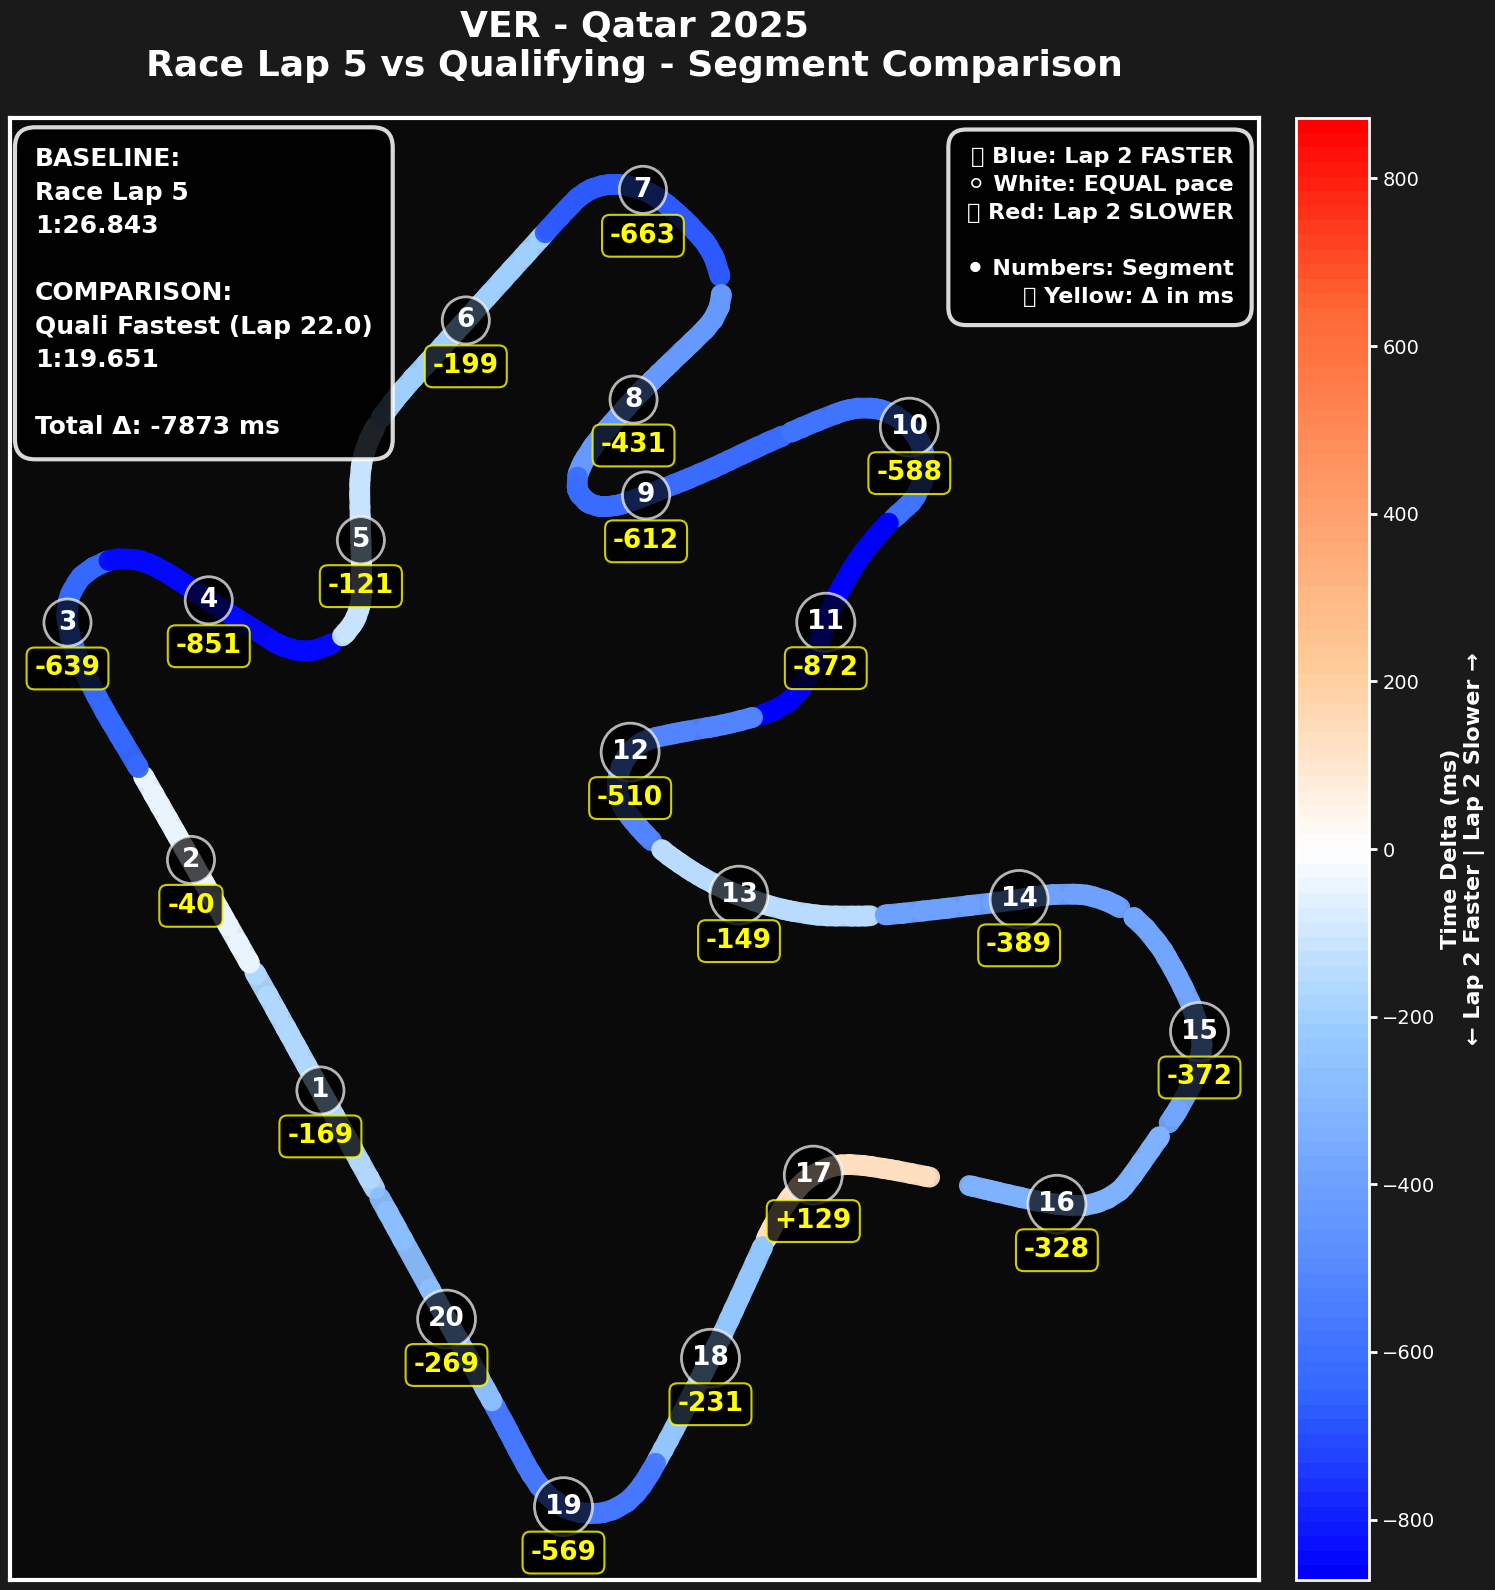

✓ Plot saved: ../f1_visualizations/ver_race5_vs_quali_qatar_2025.png


In [51]:
print("Generating Comparison 1 visualization...")
plot_mini_sector_comparison(
    comparison_1,
    race_lap_5,
    quali_fastest,
    lap1_name=f"Race Lap 5\n{format_laptime(race_lap_5['LapTime'])}",
    lap2_name=f"Quali Fastest (Lap {quali_fastest['LapNumber']})\n{format_laptime(quali_fastest['LapTime'])}",
    title=f"{DRIVER} - {RACE} {YEAR}\nRace Lap 5 vs Qualifying - Segment Comparison",
    filename=f"{DRIVER.lower()}_race5_vs_quali_{RACE.lower()}_{YEAR}.png",
    max_delta=global_max_delta
)

Generating Comparison 2 visualization...
✓ Function 'plot_mini_sector_comparison()' defined - F1 GRADE VISUALIZATION


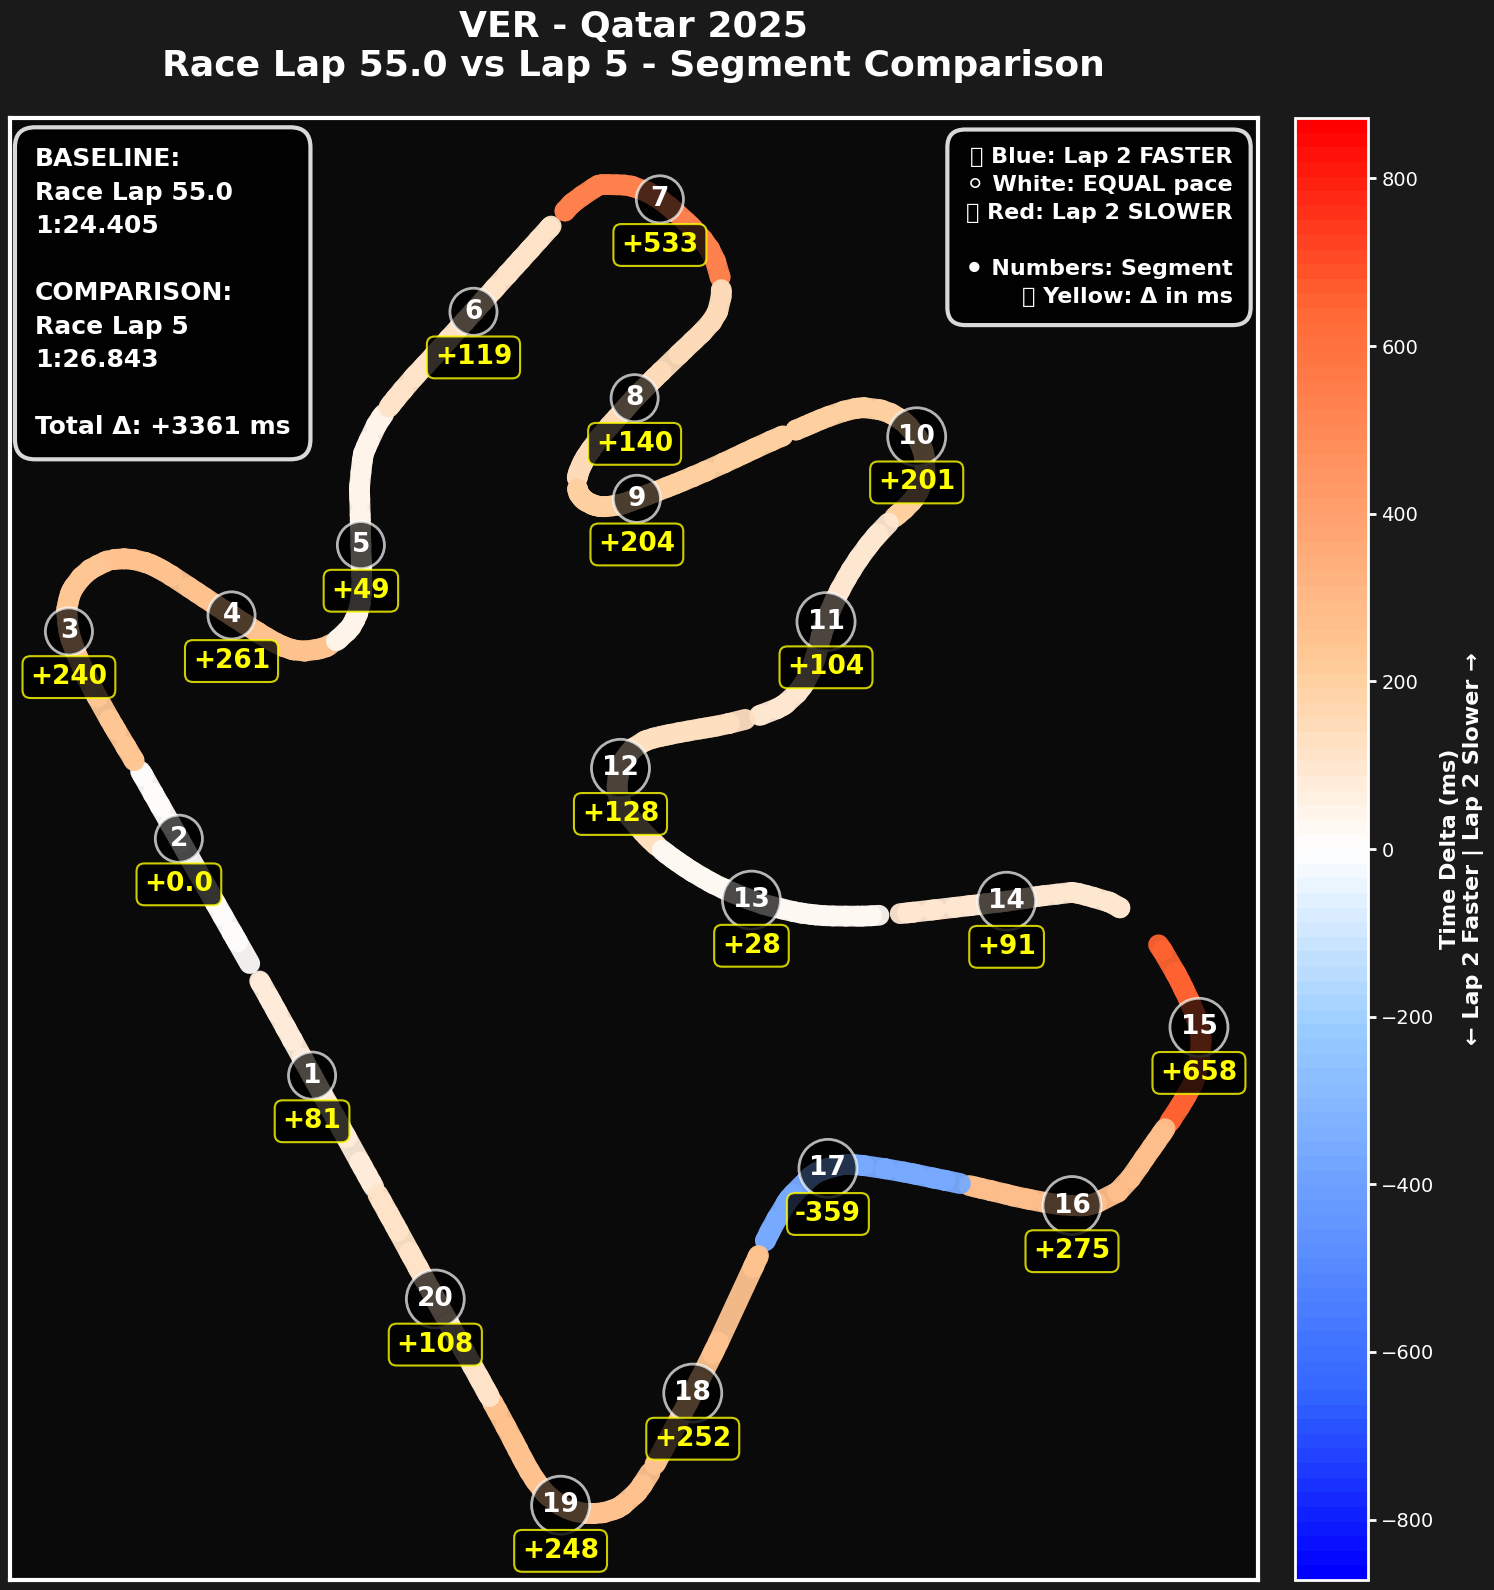

✓ Plot saved: ../f1_visualizations/ver_late_race_vs_race5_qatar_2025.png


In [52]:
print("Generating Comparison 2 visualization...")
plot_mini_sector_comparison(
    comparison_2,
    race_lap_late,
    race_lap_5,
    lap1_name=f"Race Lap {third_last_lap_num}\n{format_laptime(race_lap_late['LapTime'])}",
    lap2_name=f"Race Lap 5\n{format_laptime(race_lap_5['LapTime'])}",
    title=f"{DRIVER} - {RACE} {YEAR}\nRace Lap {third_last_lap_num} vs Lap 5 - Segment Comparison",
    filename=f"{DRIVER.lower()}_late_race_vs_race5_{RACE.lower()}_{YEAR}.png",
    max_delta=global_max_delta
)

Generating Comparison 3 visualization...
✓ Function 'plot_mini_sector_comparison()' defined - F1 GRADE VISUALIZATION


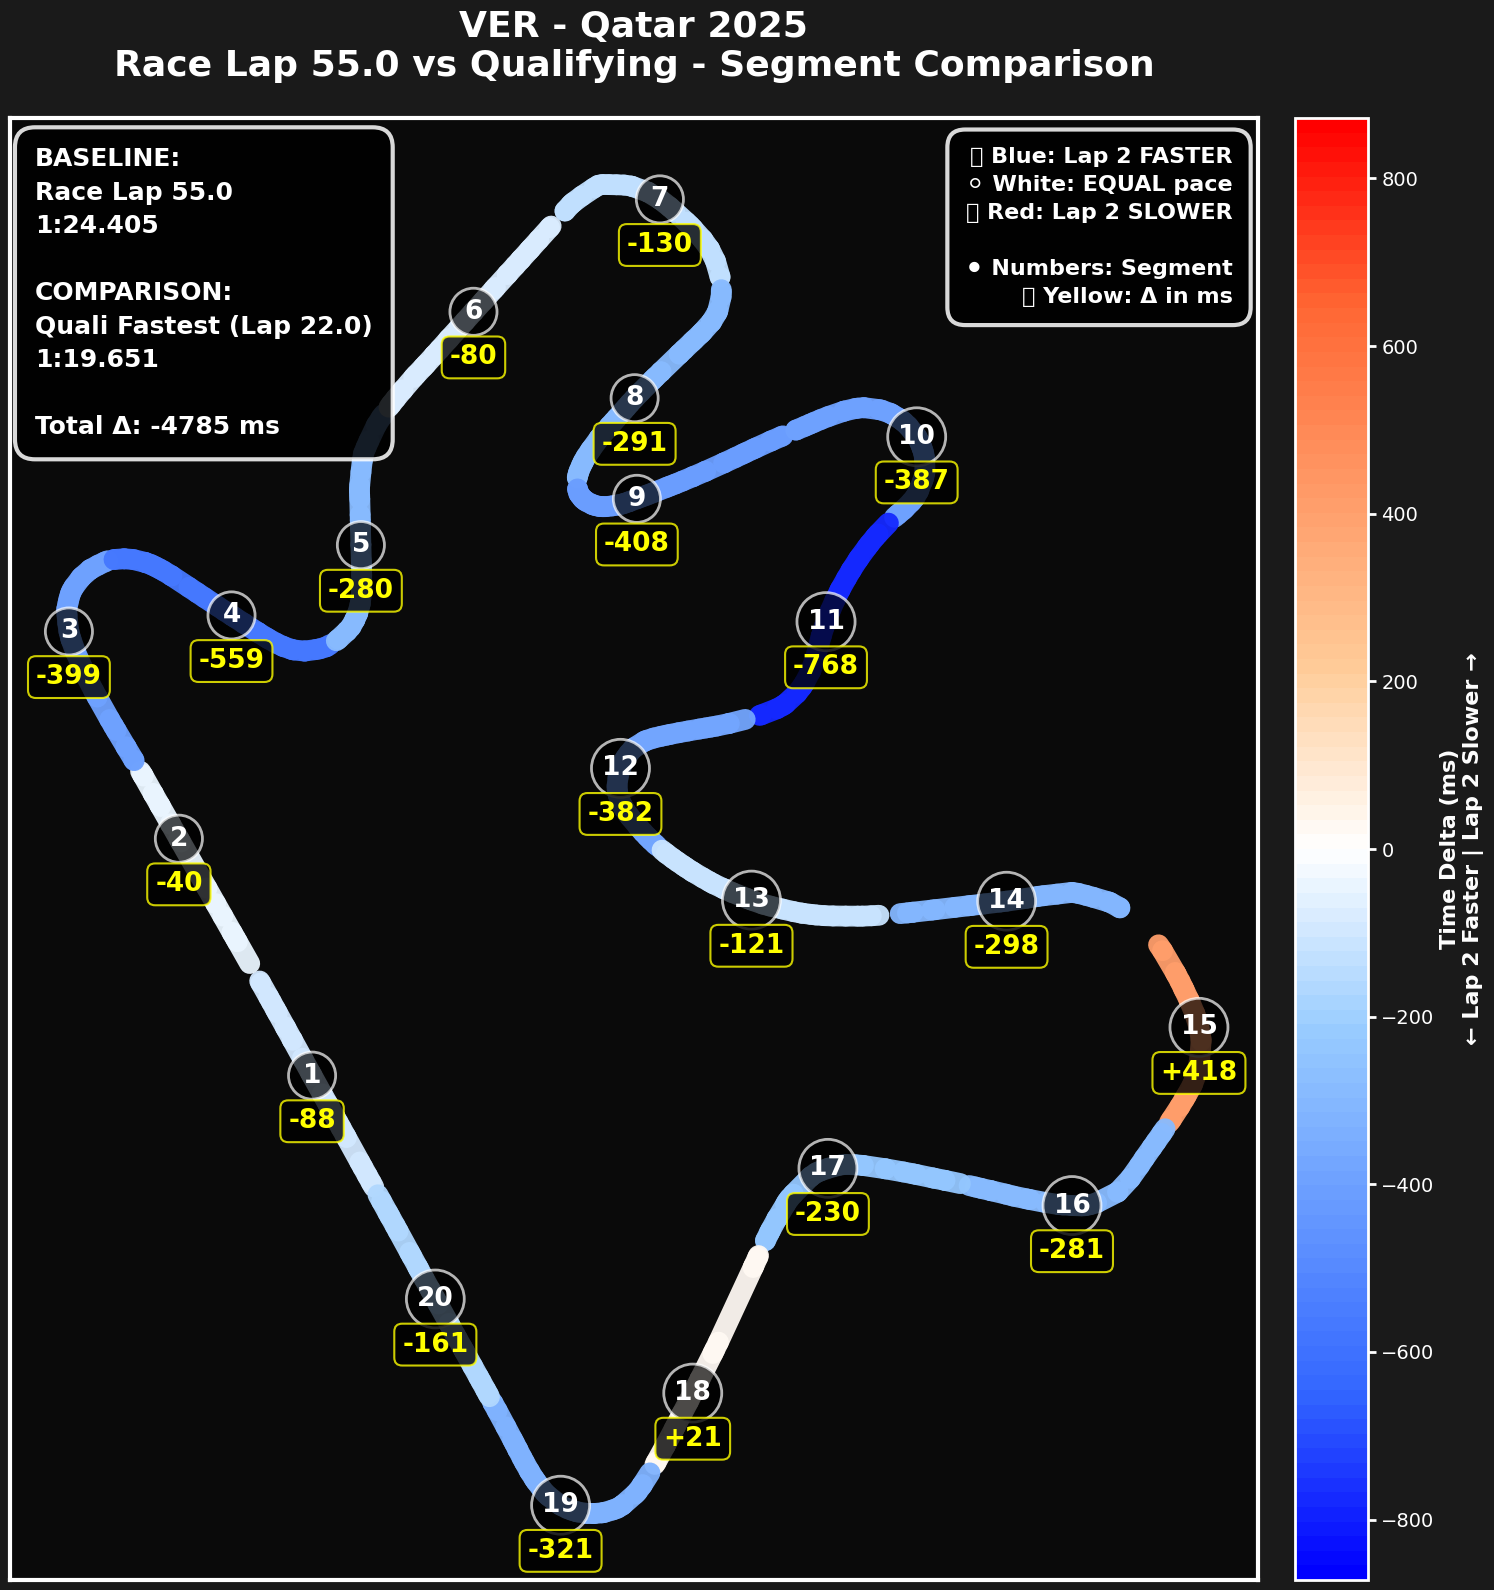

✓ Plot saved: ../f1_visualizations/ver_late_race_vs_quali_qatar_2025.png


In [53]:
print("Generating Comparison 3 visualization...")
plot_mini_sector_comparison(
    comparison_3,
    race_lap_late,
    quali_fastest,
    lap1_name=f"Race Lap {third_last_lap_num}\n{format_laptime(race_lap_late['LapTime'])}",
    lap2_name=f"Quali Fastest (Lap {quali_fastest['LapNumber']})\n{format_laptime(quali_fastest['LapTime'])}",
    title=f"{DRIVER} - {RACE} {YEAR}\nRace Lap {third_last_lap_num} vs Qualifying - Segment Comparison",
    filename=f"{DRIVER.lower()}_late_race_vs_quali_{RACE.lower()}_{YEAR}.png",
    max_delta=global_max_delta
)